# 라이브러리 설치, 데이터 준비

## 라이브러리 설치

In [ ]:
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

# Prophet
from fbprophet import Prophet

# Prophet 시각화 도구
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

## 데이터 준비

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/한국품질재단 폴더/final/dataset.csv')

# 데이터 전처리

## ds, y 컬럼명 변경(fbprophet는 ds, y로 컬럼명 설정해야함), 데이터분리

In [ ]:
def datasplit_ts(df, cut):
    df.columns = ['ds', 'y', '금리', 'ex_종가']
    train_df = df[df['ds']<=cut]
    test_df = df[df['ds']>cut]
    return train_df, test_df

In [ ]:
train_df, test_df = datasplit_ts(df, '2021-12-31')

In [ ]:
train_df

,ds,y,금리,ex_종가
0,2017-01-02,18645,1.25,1203.93
1,2017-01-03,18776,1.25,1206.82
2,2017-01-04,18738,1.25,1196.15
3,2017-01-05,18716,1.25,1182.19
4,2017-01-06,18815,1.25,1202.00
...,...,...,...,...
1224,2021-12-24,29895,1.00,1185.99
1225,2021-12-27,29767,1.00,1185.61
1226,2021-12-28,29973,1.00,1188.09
1227,2021-12-29,30072,1.00,1184.70


## x와 y컬럼 별도 생성

In [ ]:
y_train_prophet_df = train_df[['ds','y']]
y_train_prophet_df

,ds,y
0,2017-01-02,18645
1,2017-01-03,18776
2,2017-01-04,18738
3,2017-01-05,18716
4,2017-01-06,18815
...,...,...
1224,2021-12-24,29895
1225,2021-12-27,29767
1226,2021-12-28,29973
1227,2021-12-29,30072


In [ ]:
x_col = [i for i in train_df.columns if i not in ['ds','y']]
x_train_prophet_df = train_df[x_col]
x_train_prophet_df

,금리,ex_종가
0,1.25,1203.93
1,1.25,1206.82
2,1.25,1196.15
3,1.25,1182.19
4,1.25,1202.00
...,...,...
1224,1.00,1185.99
1225,1.00,1185.61
1226,1.00,1188.09
1227,1.00,1184.70


문제: fbprophet 모델에서 ds, y, x 순으로 넣는데 x가 반영안됨  
ds, y만으로 prophet 모델 적용

In [ ]:
yx_train_prophet_df = pd.concat(
                                [y_train_prophet_df, x_train_prophet_df],
                                 axis=1)

# fbprophet 모델

## prophet 모델 생성 및 적용

In [ ]:
prophet = Prophet(
                  # linear, logistic(cap, floor)
                  # growth='linear',

                  # Trend
                  # changepoint: 트렌드가 변하는 지점
                  changepoints=None, # CP가 발생하는 시점 ex. ['2012-01-01']
                  n_changepoints=25, # CP의 수
                  changepoint_range=0.8,
                  changepoint_prior_scale=0.05,

                  # Seasonality
                  seasonality_mode = 'additive',
                  yearly_seasonality=True, 
                  weekly_seasonality=True,
                  daily_seasonality=True)

fit_prophet = prophet.fit(yx_train_prophet_df)

## 4개월간 예측

In [ ]:
y_train_prophet_df

,ds,y
0,2017-01-02,18645
1,2017-01-03,18776
2,2017-01-04,18738
3,2017-01-05,18716
4,2017-01-06,18815
...,...,...
1224,2021-12-24,29895
1225,2021-12-27,29767
1226,2021-12-28,29973
1227,2021-12-29,30072


In [ ]:
y_train_prophet_df[['ds']].dtypes

ds    datetime64[ns]
dtype: object

In [ ]:
y_train_prophet_df['ds'] = pd.to_datetime(y_train_prophet_df['ds'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
forecast = fit_prophet.make_future_dataframe(freq='d', periods=120)

# predict
pred__prophet = fit_prophet.predict(forecast)

In [ ]:
forecast

,ds
0,2017-01-02
1,2017-01-03
2,2017-01-04
3,2017-01-05
4,2017-01-06
...,...
1344,2022-04-25
1345,2022-04-26
1346,2022-04-27
1347,2022-04-28


In [ ]:
pred__prophet[-10:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1381,2022-06-01,27314.529936,21405.180733,32617.254716,22038.592903,33316.105724,-583.283638,-583.283638,-583.283638,-724.569716,-724.569716,-724.569716,141.286078,141.286078,141.286078,0.0,0.0,0.0,26731.246298
1382,2022-06-02,27296.546022,21207.324216,32709.922653,21988.313299,33373.515303,-562.516151,-562.516151,-562.516151,-722.993814,-722.993814,-722.993814,160.477663,160.477663,160.477663,0.0,0.0,0.0,26734.029871
1383,2022-06-03,27278.562109,21125.334316,32837.340268,21901.871569,33460.214478,-549.708111,-549.708111,-549.708111,-728.755027,-728.755027,-728.755027,179.046916,179.046916,179.046916,0.0,0.0,0.0,26728.853999
1384,2022-06-04,27260.578196,22126.597076,33619.736503,21815.429840,33507.207550,423.546369,423.546369,423.546369,226.960134,226.960134,226.960134,196.586235,196.586235,196.586235,0.0,0.0,0.0,27684.124565
1385,2022-06-05,27242.594282,22106.361850,33823.017749,21728.988111,33538.368573,439.658304,439.658304,439.658304,226.960511,226.960511,226.960511,212.697793,212.697793,212.697793,0.0,0.0,0.0,27682.252586
1386,2022-06-06,27224.610369,20971.688542,33016.043809,21642.546381,33642.475976,-506.328883,-506.328883,-506.328883,-733.329903,-733.329903,-733.329903,227.001020,227.001020,227.001020,0.0,0.0,0.0,26718.281486
1387,2022-06-07,27206.626456,20955.807554,33197.932287,21556.104652,33688.376797,-482.571470,-482.571470,-482.571470,-721.711408,-721.711408,-721.711408,239.139938,239.139938,239.139938,0.0,0.0,0.0,26724.054986
1388,2022-06-08,27188.642542,20998.596028,33158.693458,21469.662923,33726.747884,-475.779544,-475.779544,-475.779544,-724.569716,-724.569716,-724.569716,248.790172,248.790172,248.790172,0.0,0.0,0.0,26712.862998
1389,2022-06-09,27170.658629,21126.667460,33162.283069,21382.108686,33758.902611,-467.328313,-467.328313,-467.328313,-722.993814,-722.993814,-722.993814,255.665501,255.665501,255.665501,0.0,0.0,0.0,26703.330316
1390,2022-06-10,27152.674716,20563.998421,33099.945548,21289.729631,33788.744308,-469.231242,-469.231242,-469.231242,-728.755027,-728.755027,-728.755027,259.523785,259.523785,259.523785,0.0,0.0,0.0,26683.443474


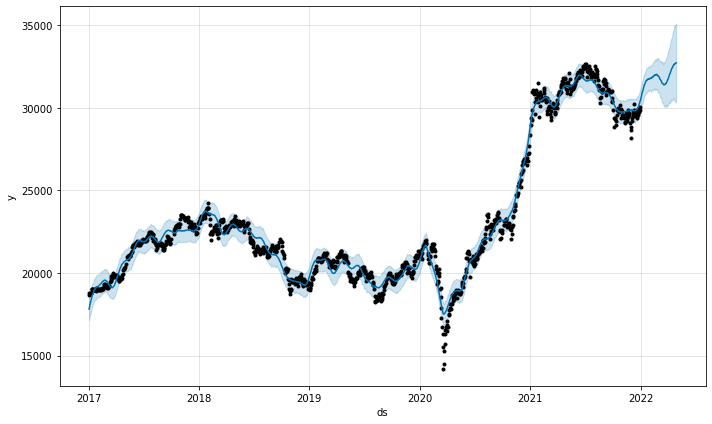

In [ ]:
fig1 = fit_prophet.plot(pred__prophet)

# 4. 검증

## 예측결과 202201-04 추출

In [ ]:
pred__prophet_y = pred__prophet[['ds','yhat']].tail(120)
pred__prophet_y

,ds,yhat
1229,2021-12-31,30445.362180
1230,2022-01-01,30481.016793
1231,2022-01-02,30553.492007
1232,2022-01-03,30642.762484
1233,2022-01-04,30736.115034
...,...,...
1344,2022-04-25,32671.268207
1345,2022-04-26,32701.772433
1346,2022-04-27,32707.420114
1347,2022-04-28,32728.034256


## 실제데이터 ds, y 설정 및 타입변환

In [ ]:
test_df_y = test_df[['ds','y']]
test_df_y['ds'] = pd.to_datetime(test_df_y['ds'])
test_df_y.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ds    datetime64[ns]
y              int64
dtype: object

## 실제데이터, 예측데이터 merge(휴일데이터 제거)

In [ ]:
test_pred_df = pd.merge(test_df_y, pred__prophet_y, on='ds', how='left')
test_pred_df

,ds,y,yhat
0,2022-01-03,30023,30642.762484
1,2022-01-04,30013,30736.115034
2,2022-01-05,29599,30807.690842
3,2022-01-06,29333,30896.581693
4,2022-01-07,29629,30962.195818
...,...,...,...
75,2022-04-25,26818,32671.268207
76,2022-04-26,26916,32701.772433
77,2022-04-27,26690,32707.420114
78,2022-04-28,26960,32728.034256


In [ ]:
test_y = test_pred_df[['y']].values

In [ ]:
pred_y = test_pred_df[['yhat']].values

## mae값 도출

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, pred_y)
print('MAE: %.3f' % mae)

MAE: 4131.124


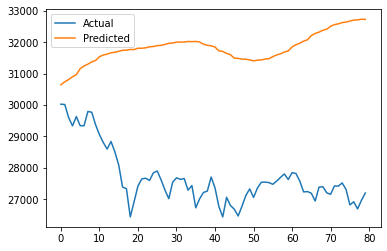

In [ ]:
from matplotlib import pyplot

pyplot.plot(test_y, label='Actual')
pyplot.plot(pred_y, label='Predicted')
pyplot.legend()
pyplot.show()

# 전체코드

In [30]:
## 전체코드(데이터 불러오기 및 전처리, 함수)

import pandas as pd
import numpy as np
from matplotlib import pyplot

# Prophet
from fbprophet import Prophet

# Prophet 시각화 도구
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import add_changepoints_to_plot

from google.colab import drive
drive.mount('/content/drive')

# 평가지표
from sklearn.metrics import mean_absolute_error, mean_squared_error

def RMSE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.sqrt(np.mean((y_test - y_pred)**2))   
    #return np.sqrt(MSE(y_test - y_pred))

def MAPE(y_test, y_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100


df = pd.read_csv('/content/drive/My Drive/한국품질재단 폴더/final/dataset.csv')

def datasplit_ts(df, cut):
    df.columns = ['ds', 'y', '금리', 'ex_종가']
    train_df = df[df['ds']<=cut]
    test_df = df[df['ds']>cut]
    return train_df, test_df

train_df, test_df = datasplit_ts(df, '2021-12-31')

y_train_prophet_df = train_df[['ds','y']]
# y_train_prophet_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
## 전체코드(모델 생성)

# prophet 객체 생성
prophet = Prophet(
                # linear or nonlinear
                growth='linear',

                # Trend -> 변화하는 포인트
                changepoints=None, # CP가 발생하는 시점들의 list -> 직접 날짜 지정 가능 ex.['2018-01-02']
                n_changepoints=25, # CP의 수
                changepoint_range=0.9, # CP의 기존 데이터 수 대비 최대 비율
                changepoint_prior_scale=0.6, # CP 추정 민감도로 높을수록 민감(많은 cp를 추정하려면 올려야함) -> 낮으면 과소적합, 높으면 과대적합

                # Seasonality
                seasonality_mode = 'additive',
                seasonality_prior_scale=10,
                yearly_seasonality=10, 
                weekly_seasonality=20,
                daily_seasonality=False)

# fit
fit_prophet = prophet.fit(y_train_prophet_df)
# 예측 1-4월
forecast = fit_prophet.make_future_dataframe(freq='d', periods=120)
# forecast['cap'] = 35000
# forecast['floor'] = 10000
# predict
pred__prophet = fit_prophet.predict(forecast)

## 검증
# 예측결과에서 1-4월만 추출
pred__prophet_y = pred__prophet[['ds','yhat']].tail(120)

# 실데이터 ds, y만 추출
test_df_y = test_df[['ds','y']]
test_df_y['ds'] = pd.to_datetime(test_df_y['ds'])

# 실제데이터와 예측데이터 merge(예측데이터에 있는 주말, 휴일 데이터를 거르기 위함)
test_pred_df = pd.merge(test_df_y, pred__prophet_y, on='ds', how='left')

# 값 입력
test_y = test_pred_df[['y']].values
pred_y = test_pred_df[['yhat']].values

AttributeError: ignored

In [ ]:
# pred__prophet [-10:]

In [8]:
# fig1 = fit_prophet.plot(pred__prophet)}

RMSE: nan


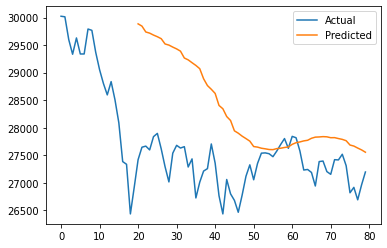

In [22]:
# rmse도출
rmse = RMSE(test_y, pred_y)
print('RMSE: %.3f' % rmse)

# mae값 도출
# mae = mean_absolute_error(test_y, pred_y)
# print('MAE: %.3f' % mae)

# # mape값 도출
# mape = MAPE(test_y, pred_y)
# print('MAPE: %.3f' % mape)

# mse값 도출
# mse = mean_squared_error(test_y, pred_y)
# print('MSE: %.3f' % mse)


pyplot.plot(test_y, label='Actual')
pyplot.plot(pred_y, label='Predicted')
pyplot.legend()
pyplot.show()

# GridSearch

In [ ]:
from sklearn.model_selection import ParameterGrid
params_grid = {
                'growth': ["linear"], 
                # changepoint
                'changepoints': [None], 
                'n_changepoints': [25, 50], 
                'changepoint_range': [0.9],
                'changepoint_prior_scale': [0.2, 0.4],
               
                # seasonal
                'seasonality_mode': ["additive"],
                'seasonality_prior_scale': [10, 15, 20],
                'yearly_seasonality': ['auto'],
                'weekly_seasonality': ['auto'],
                'daily_seasonality': [False],
               
                # etc
                # 'mcmc_samples': [0],
                'interval_width': [0.25, 0.5, 0.75],
                # 'uncertainty_samples': [0]
               }
grid = ParameterGrid(params_grid)
cnt=0
for p in grid:
  print(p)
  cnt = cnt+1
# print([p, for p in grid])
print('Total Possible Models',cnt)

{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': Fals

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error

def RMSE(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.sqrt(np.mean((y_test - y_pred)**2))

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])

for i, p in enumerate(grid, start = 1):

    print(p)
    train_model =Prophet(
                         growth = p['growth'],

                         # changepoint
                         changepoints = p['changepoints'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range = p['changepoint_range'],
                         changepoint_prior_scale = p['changepoint_prior_scale'],

                         # seasonal
                         seasonality_mode = p['seasonality_mode'],
                         seasonality_prior_scale = p['seasonality_prior_scale'],
                         weekly_seasonality= p['weekly_seasonality'],
                        #  daily_seasonality = p['daily_seasonality'],
                         yearly_seasonality = p['yearly_seasonality'],
                         interval_width = p['interval_width']
                         )
    
    fit_prophet = train_model.fit(y_train_prophet_df)

    # 예측 1-4월
    forecast = fit_prophet.make_future_dataframe(freq='d', periods=120)

    # predict
    pred__prophet = fit_prophet.predict(forecast)

    ## 검증
    # 예측결과에서 1-4월만 추출
    pred__prophet_y = pred__prophet[['ds','yhat']].tail(120)

    # 실데이터 ds, y만 추출
    test_df_y = test_df[['ds','y']]
    test_df_y['ds'] = pd.to_datetime(test_df_y['ds'])

    # 실제데이터와 예측데이터 merge(예측데이터에 있는 주말, 휴일 데이터를 거르기 위함)
    test_pred_df = pd.merge(test_df_y, pred__prophet_y, on='ds', how='left')

    # 값 입력
    test_y = test_pred_df[['y']].values
    pred_y = test_pred_df[['yhat']].values
    rmse = RMSE(test_y, pred_y)
    print(i, 'Mean Absolute Percentage Error(RMSE)------------------------------------',rmse)
    model_parameters = model_parameters.append({'RMSE':rmse,'Parameters':p},ignore_index=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1 Mean Absolute Percentage Error(RMSE)------------------------------------ 1355.632427450969
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2 Mean Absolute Percentage Error(RMSE)------------------------------------ 1303.46055415133
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3 Mean Absolute Percentage Error(RMSE)------------------------------------ 1336.4619162797753
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4 Mean Absolute Percentage Error(RMSE)------------------------------------ 2381.922425526544
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5 Mean Absolute Percentage Error(RMSE)------------------------------------ 2421.3763884727573
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6 Mean Absolute Percentage Error(RMSE)------------------------------------ 2441.370800526584
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7 Mean Absolute Percentage Error(RMSE)------------------------------------ 1355.632427450969
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8 Mean Absolute Percentage Error(RMSE)------------------------------------ 1303.46055415133
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9 Mean Absolute Percentage Error(RMSE)------------------------------------ 1336.4619162797753
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10 Mean Absolute Percentage Error(RMSE)------------------------------------ 2381.922425526544
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11 Mean Absolute Percentage Error(RMSE)------------------------------------ 2421.3763884727573
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12 Mean Absolute Percentage Error(RMSE)------------------------------------ 2441.370800526584
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13 Mean Absolute Percentage Error(RMSE)------------------------------------ 1355.632427450969
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14 Mean Absolute Percentage Error(RMSE)------------------------------------ 1303.46055415133
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


15 Mean Absolute Percentage Error(RMSE)------------------------------------ 1336.4619162797753
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16 Mean Absolute Percentage Error(RMSE)------------------------------------ 2381.922425526544
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


17 Mean Absolute Percentage Error(RMSE)------------------------------------ 2421.3763884727573
{'changepoint_prior_scale': 0.2, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


18 Mean Absolute Percentage Error(RMSE)------------------------------------ 2441.370800526584
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19 Mean Absolute Percentage Error(RMSE)------------------------------------ 1419.1381702326075
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20 Mean Absolute Percentage Error(RMSE)------------------------------------ 1417.9962192487703
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21 Mean Absolute Percentage Error(RMSE)------------------------------------ 1431.2309331082508
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


22 Mean Absolute Percentage Error(RMSE)------------------------------------ 2576.779715865829
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23 Mean Absolute Percentage Error(RMSE)------------------------------------ 2345.7368486082164
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.25, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24 Mean Absolute Percentage Error(RMSE)------------------------------------ 2574.953724985653
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


25 Mean Absolute Percentage Error(RMSE)------------------------------------ 1419.1381702326075
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26 Mean Absolute Percentage Error(RMSE)------------------------------------ 1417.9962192487703
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


27 Mean Absolute Percentage Error(RMSE)------------------------------------ 1431.2309331082508
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28 Mean Absolute Percentage Error(RMSE)------------------------------------ 2576.779715865829
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


29 Mean Absolute Percentage Error(RMSE)------------------------------------ 2345.7368486082164
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.5, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30 Mean Absolute Percentage Error(RMSE)------------------------------------ 2574.953724985653
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31 Mean Absolute Percentage Error(RMSE)------------------------------------ 1419.1381702326075
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


32 Mean Absolute Percentage Error(RMSE)------------------------------------ 1417.9962192487703
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33 Mean Absolute Percentage Error(RMSE)------------------------------------ 1431.2309331082508
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


34 Mean Absolute Percentage Error(RMSE)------------------------------------ 2576.779715865829
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 15, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


35 Mean Absolute Percentage Error(RMSE)------------------------------------ 2345.7368486082164
{'changepoint_prior_scale': 0.4, 'changepoint_range': 0.9, 'changepoints': None, 'daily_seasonality': False, 'growth': 'linear', 'interval_width': 0.75, 'n_changepoints': 50, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20, 'weekly_seasonality': 'auto', 'yearly_seasonality': 'auto'}
36 Mean Absolute Percentage Error(RMSE)------------------------------------ 2574.953724985653


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters
0,1303.460554,"{'changepoint_prior_scale': 0.2, 'changepoint_..."
1,1303.460554,"{'changepoint_prior_scale': 0.2, 'changepoint_..."
2,1303.460554,"{'changepoint_prior_scale': 0.2, 'changepoint_..."
3,1336.461916,"{'changepoint_prior_scale': 0.2, 'changepoint_..."
4,1336.461916,"{'changepoint_prior_scale': 0.2, 'changepoint_..."


In [ ]:
parameters['Parameters'][2]

{'changepoint_prior_scale': 0.2,
 'changepoint_range': 0.9,
 'changepoints': None,
 'daily_seasonality': False,
 'growth': 'linear',
 'interval_width': 0.5,
 'n_changepoints': 25,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 15,
 'weekly_seasonality': 'auto',
 'yearly_seasonality': 'auto'}

In [1]:
## best param으로 다시 모델 적용

prophet = Prophet(
                changepoint_prior_scale= 0.2,
                changepoint_range= 0.9,
                changepoints= None,
                growth= 'linear',
                n_changepoints= 25,
                seasonality_mode= 'additive',
                seasonality_prior_scale= 15,

                daily_seasonality = False,
                weekly_seasonality= 'auto',
                yearly_seasonality= 'auto',
                mcmc_samples=0
                )



# fit
fit_prophet = prophet.fit(y_train_prophet_df)

# 예측 1-4월
forecast = fit_prophet.make_future_dataframe(freq='d', periods=120)
# forecast['cap'] = 35000
# forecast['floor'] = 10000
# predict
pred__prophet = fit_prophet.predict(forecast)

## 검증
# 예측결과에서 1-4월만 추출
pred__prophet_y = pred__prophet[['ds','yhat']].tail(120)

# 실데이터 ds, y만 추출
test_df_y = test_df[['ds','y']]
test_df_y['ds'] = pd.to_datetime(test_df_y['ds'])

# 실제데이터와 예측데이터 merge(예측데이터에 있는 주말, 휴일 데이터를 거르기 위함)
test_pred_df = pd.merge(test_df_y, pred__prophet_y, on='ds', how='left')

# 값 입력
test_y = test_pred_df[['y']].values
pred_y = test_pred_df[['yhat']].values

NameError: ignored

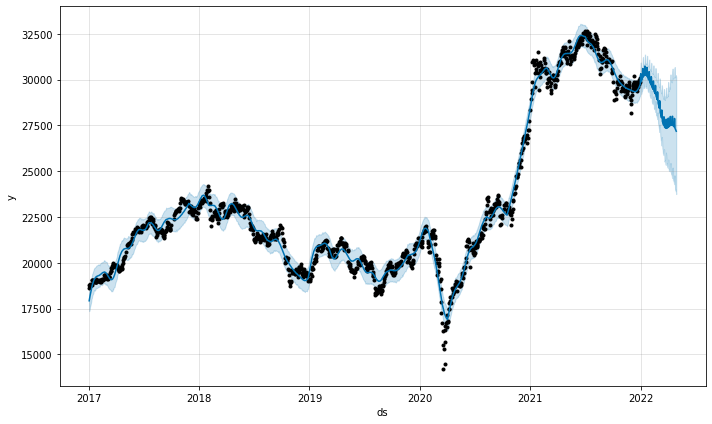

In [ ]:
fig1 = fit_prophet.plot(pred__prophet)

RMSE: 1303.461


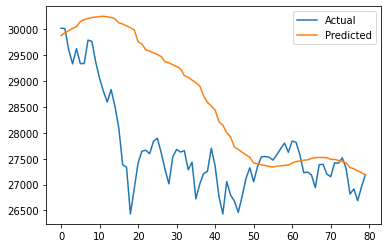

In [ ]:
# rmse도출
rmse = RMSE(test_y, pred_y)
print('RMSE: %.3f' % rmse)

pyplot.plot(test_y, label='Actual')
pyplot.plot(pred_y, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
# from fbprophet.diagnostics import cross_validation
# import fbprophet as Prophet

# df_cv = cross_validation(fit_prophet, initial='730 days', period='180 days',horizon = '365 days')